In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Type
from torch import nn
from torch.optim import optimizer
import rasterio
import zipfile
from matplotlib import pyplot as plt
import datetime
from torchvision import transforms as transforms
import shutil
import torchmetrics
import os
import pytorch_lightning as pl
import sklearn
from torch.nn import functional as F
import tqdm

# --- GPU selection --- #
gpus = 7 # slot number (e.g., 3), no gpu use -> write just ' '
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpus)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def minmax(array : Type[np.ndarray], dim = 0):
    min = np.min(array, axis=dim)
    max = np.max(array, axis=dim)
    array = (array-min)/(max-min)
    return array

def log_minmax(array : Type[np.ndarray], dim = 0):
    min = np.min(array, axis=dim)
    array = array - min + 1
    array = np.log(array)
    max = np.max(array, axis=dim)
    array = (array)/(max)
    return array

In [5]:
def save_result(model: Type[nn.Module], dataloader : Type[DataLoader], path:str, description:str = '', reference_data:str = '', patch_size:int = 60, now = datetime.datetime.now()):
    best_model = model
    os.makedirs(os.path.join(path,f'{now.year}.{now.month}.{now.day}/', f'{description}/','tmp/'), exist_ok=True)
    zipped_results = zipfile.ZipFile(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','RESULT_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}.zip'), 'w')
    prediction = np.zeros((2400//patch_size,2400//patch_size,7))

    with tqdm.tqdm(enumerate(dataloader)) as data_pbar:
        data_pbar.set_description('Predicting...')
        for i, (data, index_OHE, index) in data_pbar:
            prediction[i, :, :] = best_model(data).detach().numpy()

    

    prediction_expanded = np.zeros((7,2400,2400))
    for i in range(2400//patch_size):
        for j in range(2400//patch_size):
            for k in range(7):
                prediction_expanded[k,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = prediction[i,j,k]

    reference_image = rasterio.open(reference_data)
    layer_index = [1,2,7,8,9,10,11]

    with tqdm.trange(prediction_expanded.shape[0]) as write_pbar:
        write_pbar.set_description('Writing data')
        for i in write_pbar:
            #print('a') 
            processed_tiff = rasterio.open(
                os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', f'Result_{layer_index[i]}_{description}.tif'),
                'w',
                driver='GTiff',
                height=prediction_expanded.shape[1],
                width=prediction_expanded.shape[2],
                count=1,
                dtype=prediction_expanded.dtype,
                crs=reference_image.crs,
                transform=reference_image.transform,
            )
            #print('b')
            processed_tiff.write(prediction_expanded[i,:,:],1)
            processed_tiff.close()
            #print('c')
            zipped_results.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', f'Result_{layer_index[i]}_{description}.tif'), f'Result_{layer_index[i]}_{description}.tif')

    zipped_results.close()
    return os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','RESULT_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}.zip')


In [6]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=13, train_rate: float = 0.8, batch_size: int = 60, path:str = '../Data/N12/Model/', description:str = 'no_description', reference_data:str = ''): 
    train_loss_history = []
    valid_loss_history = []

    patch_size = dataloaders['Train'].dataset.data.shape[-1]
    training_patches = len(dataloaders['Train'].dataset)
    validating_patches = len(dataloaders['Validation'].dataset)
    print(f'Training Patches : {training_patches}\nValidating Patches : {validating_patches}')

    best_model_epoch = 0
    least_valid_loss = 100
    now = datetime.datetime.now()
    os.makedirs(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/'), exist_ok=True)
    zipped_model = zipfile.ZipFile(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', '{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.zip'), 'w')
    
    epoch_range = tqdm.trange(num_epochs)
    for epoch in epoch_range:

        train_running_loss = 0.0
        valid_running_loss = 0.0

        epoch_range.set_description(f'EPOCH #{epoch}')
        

        for state in ['Train', 'Validation']:
            #pbar = tqdm.tqdm(dataloaders[state])
            for inputs, labels_OHE, labels in dataloaders[state]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                model.to(device)
                
                outputs = model(inputs)
                
                optimizer.zero_grad()

                if state == 'Train':
                    model.train()
                    train_loss = criterion(outputs, labels)
                    train_loss.backward()
                    train_running_loss += train_loss.item() * inputs.size(0)
                    #pbar.set_description('Train')
                
                if state == 'Validation':
                    model.eval()
                    valid_loss = criterion(outputs, labels)
                    valid_running_loss += valid_loss.item() * inputs.size(0)
                    #pbar.set_description('Valid')

                optimizer.step()
                #valid_running_similarity += metric(outputs, labels)
                #print('validating')
                
                #print(f'{i}th batch')
            #pbar.clear()
            
        epoch_range.refresh()

        
        #print(f'Memory after a training : {torch.cuda.memory_allocated()/1024/1024}')

        epoch_train_loss = train_running_loss / training_patches
        epoch_valid_loss = valid_running_loss / validating_patches
        scheduler.step(epoch_valid_loss)

        #print(f'Valid loss: {epoch_valid_loss} | Train loss: {epoch_train_loss}')


        if epoch_valid_loss < least_valid_loss:
            least_valid_loss = epoch_valid_loss
            best_model_epoch = epoch

        train_loss_history.append(epoch_train_loss)      
        valid_loss_history.append(epoch_valid_loss)

        torch.save(model.state_dict(), os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(epoch)))
        zipped_model.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(epoch)))

    plt.figure(figsize=(20,8))
    plt.plot(train_loss_history, 'r-')
    plt.plot(valid_loss_history, 'bo')
    plt.savefig(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', 'Tendency.png'), dpi=300)
    zipped_model.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', 'Tendency.png'))
    zipped_model.writestr('README.txt', f'{description}\nThe best Model : #{best_model_epoch}th model with loss {least_valid_loss}\nOptimizer : {optimizer}\nLoss function : {criterion}\nBatch size : {batch_size}\nScheduler : {scheduler}\nPatch size : {patch_size}\nTotal epochs : {num_epochs}\nModel information :\n{model.modules}')
    
    print('Best loss: {:4f}, in Epoch #{:0=3d}'.format(least_valid_loss, best_model_epoch))    
    zipped_model.close()
    shutil.copy(src=os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', '{0:0=2d}.pth'.format(epoch)), dst=os.path.join(path,f'{now.year}.{now.month}.{now.day}/', 'Best_Model_Parameters_of_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.pth'))
    print('Model information is saved in '+os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', '{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.zip'))

    model.load_state_dict(torch.load(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(best_model_epoch))))
    result_path = save_result(model = model.to('cpu'), dataloader=dataloaders['Prediction'], path=path, description=description, reference_data=reference_data, patch_size=patch_size, now=now)
    print('Model result is saved in '+ result_path)
    
    shutil.rmtree(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/'))
    best_model_path = os.path.join(path,f'{now.year}.{now.month}.{now.day}/', 'Best_Model_Parameters_of_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.pth')
    return best_model_path

In [7]:
def prepare_raw_files():
    '''if os.path.exists('../Data/N12/np/train_array.npy') and os.path.exists('../Data/N12/np/target_array_OHE.npy'):
        train_array = np.load('../Data/N12/np/train_array.npy')
        target_array = np.load('../Data/N12/np/target_array_OHE.npy')
    else:'''
    lidar_image = rasterio.open('../Data/N12/N12_lidar.tif').read()
    lidar_array = np.array(lidar_image)
    lidar_array = log_minmax(lidar_array, dim=(0,1))

    lidar_1n_image = rasterio.open('../Data/N12/N12_lidar_1n.tif').read()
    lidar_1n_array = np.array(lidar_1n_image)
    lidar_1n_array = log_minmax(lidar_1n_array, dim=(0,1))

    lidar_nt_image = rasterio.open('../Data/N12/N12_lidar_nt.tif').read()
    lidar_nt_array = np.array(lidar_nt_image)
    lidar_nt_array = log_minmax(lidar_nt_array, dim=(0,1))

    RGB2020_image = rasterio.open('../Data/N12/N12_RGB2020.tif').read()
    RGB2020_array = np.array(RGB2020_image)

    train_array = np.stack([lidar_array, lidar_1n_array, lidar_nt_array]).squeeze()
    train_array = np.concatenate((train_array,RGB2020_array))
    target_image = rasterio.open('../Data/N12/N12_newlc.tif').read()
    target_array = np.array(target_image, dtype=int).squeeze()
    target_array = np.where(target_array == 1, 0, target_array)
    target_array = np.where(target_array == 2, 1, target_array)
    target_array = np.where(target_array == 7, 2, target_array)
    target_array = np.where(target_array == 8, 3, target_array)
    target_array = np.where(target_array == 9, 4, target_array)
    target_array = np.where(target_array == 10, 5, target_array)
    target_array = np.where(target_array == 11, 6, target_array)

    target_array_OHE = np.zeros(shape=(7,2400,2400))
    num = np.unique(target_array)
    num = num.shape[0]
    encoded_target_array = np.eye(num)[target_array]
    for i in range(encoded_target_array.shape[-1]):
        target_array_OHE[i,:,:]=encoded_target_array[:,:,i]

    return train_array, target_array.astype(int), target_array_OHE.astype(int)

In [8]:
class TrainDataset2(Dataset):
    def __init__(self, data_array : Type[np.ndarray], target_array_OHE : Type[np.ndarray], target_array_RAW : Type[np.ndarray], patch_size : int, is_evaluating : bool = False, is_validating : bool = False, rotate : bool = False, train_ratio : float = 0.8):
        self.is_validating = is_validating
        self.is_evaluating = is_evaluating
        seed = 386579

        #print(f'Data shape: {data_array.shape} | Target shape: {target_array.shape}')

        self.data = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size), data_array.shape[0], patch_size, patch_size))

        for i in range(0,data_array.shape[1]//patch_size):
            for j in range(0,data_array.shape[2]//patch_size):
                self.data[data_array.shape[1]//patch_size*i+j,:,:,:] = data_array[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

        self.label_OHE = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size), target_array_OHE.shape[0] ,patch_size, patch_size), dtype=float)
        for k in range(0,data_array.shape[1]//patch_size):
            for l in range(0,data_array.shape[2]//patch_size):
                self.label_OHE[data_array.shape[1]//patch_size*k+l,:,:,:] = target_array_OHE[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

        self.label_RAW = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size),data_array.shape[0]+1))
        for k in range(0,data_array.shape[1]//patch_size):
            for l in range(0,data_array.shape[2]//patch_size):
                self.label_RAW[data_array.shape[1]//patch_size*k+l,:] = np.bincount(target_array_RAW[k*patch_size:(k+1)*patch_size, l*patch_size:(l+1)*patch_size].reshape(-1), minlength=7)/(patch_size*patch_size)


        if not is_evaluating:
            if rotate:
                for i in range(2):
                    rotated_data = np.rot90(self.data, k=i+1, axes=(-2, -1))
                    self.data = np.concatenate((self.data, rotated_data), axis=0)
                    rotated_label_OHE = np.rot90(self.label_OHE, k=i+1, axes=(-2, -1))
                    rotated_label_RAW = self.label_RAW
                    self.label_OHE = np.concatenate((self.label_OHE, rotated_label_OHE), axis=0)
                    self.label_RAW = np.concatenate((self.label_RAW, rotated_label_RAW), axis=0)

        train_size = int(self.data.shape[0]*train_ratio)
        index_array = np.random.RandomState(seed=seed).permutation(self.data.shape[0])
        self.train_index = index_array[0:train_size]
        self.valid_index = index_array[train_size:index_array.shape[0]]
        
        self.data = torch.as_tensor(self.data).float()
        self.label_OHE = torch.as_tensor(self.label_OHE).float()
        self.label_RAW = torch.as_tensor(self.label_RAW).float()

        self.data[:,3:6,:,:] = self.data[:,3:6,:,:]/255

    def __len__(self):
        if self.is_evaluating:
            return self.data.shape[0]

        if self.is_validating:
            return self.valid_index.shape[0]
        else:
            return self.train_index.shape[0]

    def __getitem__(self, idx):
        if self.is_evaluating:
            sample = torch.as_tensor(self.data[idx,:,:,:]).float()
            label_OHE = torch.as_tensor(self.label_OHE[idx,:]).float()
            label_RAW = torch.as_tensor(self.label_RAW[idx,:]).float()
            return sample, label_OHE, label_RAW
        
        if self.is_validating:
            sample = torch.as_tensor(self.data[self.valid_index[idx],:,:,:]).float()
            label_OHE = torch.as_tensor(self.label_OHE[self.valid_index[idx],:]).float()
            label_RAW = torch.as_tensor(self.label_RAW[self.valid_index[idx],:]).float()
        else:
            sample = torch.as_tensor(self.data[self.train_index[idx],:,:,:]).float()
            label_OHE = torch.as_tensor(self.label_OHE[self.train_index[idx],:]).float()
            label_RAW = torch.as_tensor(self.label_RAW[self.train_index[idx],:]).float()

        return sample, label_OHE, label_RAW

In [9]:
def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, BatchNorm=None):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size, stride, 0, dilation,
                               groups=inplanes, bias=bias)
        self.bn = BatchNorm(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], dilation=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

In [10]:
class ConvBN(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, dilation = 1, affine=True, fix_padding = False):
        super(ConvBN, self).__init__()
        self.fix_padding = fix_padding
        self.conv2d = nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, groups=C_in, bias=False, dilation=dilation)
        self.pointwise = nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False)
        self.batchnorm = nn.BatchNorm2d(C_in, affine=affine)
        

    def forward(self, x):
        if self.fix_padding:
           x = fixed_padding(x, self.conv2d.kernel_size[0], dilation=self.conv2d.dilation[0])
        x = self.conv2d(x)
        x = self.batchnorm(x)
        x = self.pointwise(x)
        return x

In [11]:
class UrbanGreenRegression(nn.Module):
    def __init__(self):
        super(UrbanGreenRegression, self).__init__()
        '''self.conv_block_1 = nn.Sequential(
            ConvBN(6,32,3,1),#98
            nn.ReLU(),
            ConvBN(32,32,3,1),#96
            nn.ReLU(),
            ConvBN(32,32,3,1),#94
            nn.ReLU(),
            nn.MaxPool2d(2)#47
        )
        self.conv_block_2 = nn.Sequential(
            ConvBN(32,64,3,1),#45
            nn.ReLU(),
            ConvBN(64,64,3,1),#43
            nn.ReLU(),
            ConvBN(64,64,3,1),#41
            nn.ReLU(),
            nn.MaxPool2d(2)#8
        )'''

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(6,1,kernel_size=1,stride=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

        self.fc_block_1 = nn.Sequential(
            nn.Linear(in_features=100, out_features=256, bias=False),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256, bias=False),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256, bias=False),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256, bias=False),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU()
        )

        self.fc_block_2 = nn.Sequential(
            nn.Linear(in_features=256, out_features=64, bias=False),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,7, False),
            nn.BatchNorm1d(7)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        #x = self.conv_block_2(x)
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.fc_block_1(x)
        x = self.fc_block_2(x)
        return torch.softmax(x, dim=-1)

In [12]:
raw_data_array ,raw_target_array, OHE_target_array = prepare_raw_files()
batch_size = 6400
patch_size = 10
train_ratio = 0.8
rotate_training_data = False
Datasets_NON_OHE = {
    'Train' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio),
    'Validation' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio),
    'Prediction' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
}

In [13]:
Dataloaders_NON_OHE = {
    'Train' : DataLoader(Datasets_NON_OHE['Train'], batch_size=batch_size),
    'Validation' : DataLoader(Datasets_NON_OHE['Validation'], batch_size=batch_size),
    'Prediction' : DataLoader(Datasets_NON_OHE['Prediction'], batch_size=2400//patch_size)
}

In [14]:
from torchsummary import summary
model_for_summary = UrbanGreenRegression()
model_for_summary.to(device)
summary(model_for_summary, input_size=(6,10,10), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 1, 10, 10]               7
       BatchNorm2d-2            [64, 1, 10, 10]               2
              ReLU-3            [64, 1, 10, 10]               0
            Linear-4                  [64, 256]          25,600
       BatchNorm1d-5                  [64, 256]             512
              ReLU-6                  [64, 256]               0
            Linear-7                  [64, 256]          65,536
       BatchNorm1d-8                  [64, 256]             512
              ReLU-9                  [64, 256]               0
           Linear-10                  [64, 256]          65,536
      BatchNorm1d-11                  [64, 256]             512
             ReLU-12                  [64, 256]               0
           Linear-13                  [64, 256]          65,536
      BatchNorm1d-14                  [

Training Patches : 46080
Validating Patches : 11520


EPOCH #99: 100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


Best loss: 0.056393, in Epoch #099
Model information is saved in /home/bcyoon/Byeongchan/Data/N12/Model/Segmentation/Regression/2022.7.26/patch_10_pointwiseConv/15:32_patch_10_pointwiseConv.zip


Predicting...: : 240it [00:02, 86.95it/s] 


RasterioIOError: : No such file or directory

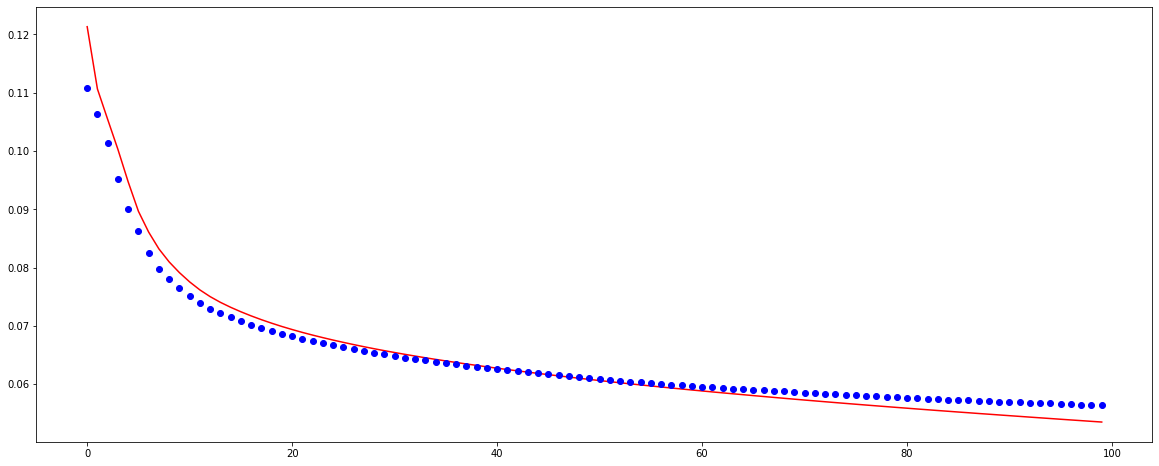

In [15]:
model2 = UrbanGreenRegression()
criterion2 = torch.nn.MSELoss(reduction='mean')
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=5, factor=0.75)
best_model_path = train_model(model2, Dataloaders_NON_OHE, criterion2, optimizer2, scheduler2, device, num_epochs=100, batch_size=batch_size, path='/home/bcyoon/Byeongchan/Data/N12/Model/Segmentation/Regression/', description='patch_10_pointwiseConv')

In [17]:
best_model_path = '/home/bcyoon/Byeongchan/Data/N12/Model/Segmentation/Regression/2022.7.26/Best_Model_Parameters_of_15:32_patch_10_pointwiseConv.pth'
model2.load_state_dict(torch.load(best_model_path))
result_path = save_result(model = model2.to('cpu'), dataloader=Dataloaders_NON_OHE['Prediction'], path='/home/bcyoon/Byeongchan/Data/N12/Model/Segmentation/Regression/', description='patch_10_pointwiseConv', reference_data='/home/bcyoon/Byeongchan/Data/N12/N12_lidar.tif', patch_size=patch_size, now=datetime.datetime.now())

Predicting...: : 240it [00:03, 72.82it/s]
Writing data: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]


In [30]:
class ConvBN(nn.Module):
    def __init__(self, Cin, Cout, kernel_size, stride=1):
        super(ConvBN,self).__init__()
        self.conv = nn.Conv2d(Cin, Cin, kernel_size=kernel_size, stride=stride, groups=Cin, bias=False)
        self.batchnorm = nn.BatchNorm2d(Cin)
        self.pointwise = nn.Conv2d(Cin, Cout, kernel_size=1, padding=0, bias=False)
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.pointwise(x)
        return x

In [ ]:
class SegBlock(nn.Module):
    def __init__(self, skip:bool, in_channel:int, out_channel:int, is_last:bool = False):
        super(SegBlock,self).__init__()
        self.skip = skip
        self.is_last = is_last
        self.conv1 = ConvBN(in_channel, out_channel, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = ConvBN(out_channel, out_channel, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

In [31]:
model_for_summary = SegBlock(skip=True, in_channel=64, out_channel=128)
model_for_summary.to(device)
summary(model_for_summary, input_size=(64,140,140), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 138, 138]             576
       BatchNorm2d-2         [16, 64, 138, 138]             128
            Conv2d-3        [16, 128, 138, 138]           8,192
            ConvBN-4        [16, 128, 138, 138]               0
              ReLU-5        [16, 128, 138, 138]               0
            Conv2d-6        [16, 128, 136, 136]           1,152
       BatchNorm2d-7        [16, 128, 136, 136]             256
            Conv2d-8        [16, 128, 136, 136]          16,384
            ConvBN-9        [16, 128, 136, 136]               0
             ReLU-10        [16, 128, 136, 136]               0
Total params: 26,688
Trainable params: 26,688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 76.56
Forward/backward pass size (MB): 2635.25
Params size (MB): 0.10
Estimated

In [17]:
def crop_add(skip:Type[torch.Tensor], target:Type[torch.Tensor])->torch.Tensor:
    cropped_skip = skip[:,:,(skip.shape[-2]-target.shape[-2])//2:(skip.shape[-2]+target.shape[-2])//2,(skip.shape[-1]-target.shape[-1])//2:(skip.shape[-1]+target.shape[-1])//2]
    return torch.cat((cropped_skip, target), dim=1)

### U-Net 마지막에 Fully Convolutional Layer 추가하기

In [20]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = SegBlock(True, 3,64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = SegBlock(True, 64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = SegBlock(True, 128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = SegBlock(True, 256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.dec0 = SegBlock(False, 512, 1024)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = SegBlock(False,1024,512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = SegBlock(False,512,256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = SegBlock(False,256,128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = SegBlock(False,128,64, is_last = True)

    def forward(self,x):
        enc1 = self.enc1(x)
        x = self.pool1(enc1)
        enc2 = self.enc2(x)
        x = self.pool2(enc2)
        enc3 = self.enc3(x)
        x = self.pool3(enc3)
        enc4 = self.enc4(x)
        x = self.pool4(enc4)
        x = self.dec0(x)
        x = self.upconv1(x)
        x = self.dec1(crop_add(enc4, x))
        x = self.upconv2(x)
        x = self.dec2(crop_add(enc3, x))
        x = self.upconv3(x)
        x = self.dec3(crop_add(enc2, x))
        x = self.upconv4(x)
        x = self.dec4(crop_add(enc1, x))
        return x


In [22]:
model_for_summary = UNet()
model_for_summary.to(device)
summary(model_for_summary, input_size=(3,284,284), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 3, 282, 282]              27
       BatchNorm2d-2           [4, 3, 282, 282]               6
            Conv2d-3          [4, 64, 282, 282]             192
            ConvBN-4          [4, 64, 282, 282]               0
              ReLU-5          [4, 64, 282, 282]               0
            Conv2d-6          [4, 64, 280, 280]             576
       BatchNorm2d-7          [4, 64, 280, 280]             128
            Conv2d-8          [4, 64, 280, 280]           4,096
            ConvBN-9          [4, 64, 280, 280]               0
             ReLU-10          [4, 64, 280, 280]               0
         SegBlock-11          [4, 64, 280, 280]               0
        MaxPool2d-12          [4, 64, 140, 140]               0
           Conv2d-13          [4, 64, 138, 138]             576
      BatchNorm2d-14          [4, 64, 1

## UNET에 쓸 Mirroring Extrapolation 함수 추가
## Regression 결과 Bilinear Interpolation 함수 추가
## Regression 결과 Fully Convolutional Layer에 조합할 연산 추가, 이후 다시 Convolutional Layer 추가

In [ ]:
class UrbanGreenSegmentation(pl.LightningModule):
    def __init__(self, rotate_training_data : bool = False, train_ratio : float = 0.8, patch_size : int = 100, batch_size : int = 16):
        super(UrbanGreenSegmentation, self).__init__()
        raw_data_array, OHE_target_array, raw_target_array = prepare_raw_files()
        self.batch_size = batch_size
        self.Datasets = {
            'Train' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio),
            'Validation' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio),
            'Prediction' : TrainDataset2(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
        }
        self.Dataloaders = {
            'Train' : DataLoader(self.Datasets['Train'], batch_size=batch_size),
            'Validation' : DataLoader(self.Datasets['Validation'], batch_size=batch_size),
            'Prediction' : DataLoader(self.Datasets['Prediction'], batch_size=batch_size)
        }
        

        


        pass

    def forward(self, x):
        pass

    def training_step(self, batch, batch_idx):
        pass

    def validation_step(self, batch, batch_idx):
        pass

    def predict_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        train_optimizer = torch.optim.Adam(self.parameters(), lr=0.02)
        train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(train_optimizer, T_max=10)
        return [train_optimizer], [train_scheduler]

    def train_dataloader(self):
        return DataLoader(self.Datasets['Train'], batch_size = self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.Datasets['Validation'], batch_size = self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.Datasets['Prediction'], batch_size = self.batch_size)